# Torch-dreams

This library was heavily inspired from: [Feature Visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

<img src = "https://github.com/Mayukhdeb/torch-dreams/raw/master/images/banner_1.png?raw=true">

torch-dreams aims to be something like [tensorflow/lucid](https://github.com/tensorflow/lucid) but in PyTorch in order to facilitate research in neural network interpretability

## Quick start 

In [ ]:
!pip install torch-dreams  --upgrade
# !pip install git+https://github.com/Mayukhdeb/torch-dreams  ## for testing only 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch_dreams.dreamer import dreamer
import torchvision.models as models
plt.rcParams['figure.figsize'] = 5,5

In [ ]:
model = models.inception_v3(pretrained=True)
dreamy_boi = dreamer(model)

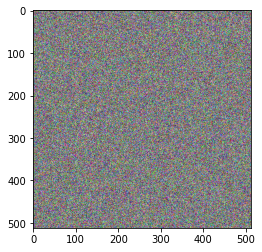

True

In [ ]:
image_sample = (np.random.rand(512,512,3).astype(np.float32) *255).astype(np.uint8)
plt.imshow(image_sample)
plt.show()
cv2.imwrite("noise.jpg", image_sample)

100%|██████████| 15/15 [00:30<00:00,  2.05s/it]


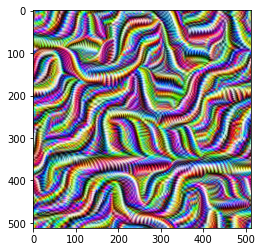

In [ ]:
config = {
    "image_path": "noise.jpg",
    "layers": [model.Mixed_5c.branch3x3dbl_3],
    "octave_scale": 1.1,
    "num_octaves": 14,
    "iterations": 70,
    "lr": 0.03,
    "max_rotation": 0.5,
}

out = dreamy_boi.deep_dream(config)
plt.imshow(out)
plt.show()

## Visualizing individual channels


We basically optimize the input image to maximize activations of a certain channel of a layer in the neural network.

In [ ]:
"""
feel free to use more layers for experiments 
"""
layers_to_use = [model.Mixed_6c.branch7x7_1.conv]


The next step now would be to define a `custom_func` that would enable use to selectively optimize a single channel. We could've made a simpler function, but this would be useful when we'll be running the optimizations on a lot of channels

In [ ]:
def make_custom_func(layer_number = 0, channel_number= 0): 
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][channel_number].mean()
        return loss
    return custom_func

Now in order to optimize the **7th channel** of the **first layer** mentioned in `layers_to_use` we define the custom loss as:



In [ ]:
my_custom_func = make_custom_func(layer_number= 0, channel_number = 7)

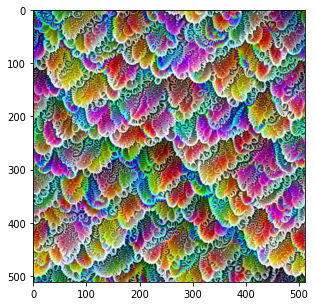

In [ ]:
config = {
    "image_path": "noise.jpg",
    "layers": layers_to_use,
    "octave_scale": 1.1,  
    "num_octaves": 20,  
    "iterations": 100,  
    "lr": 0.04,
    "max_rotation": 0.7,
    "custom_func":  my_custom_func,
}

out = dreamy_boi.deep_dream(config)
plt.imshow(out)
plt.show()

Now let us scale this up to visualize a lot more channels. If things go well, you might get something like:

<img src = "https://github.com/Mayukhdeb/torch-dreams/blob/master/images/inceptionv3_new_channels.jpeg?raw=true">

In [ ]:
channels = [7,31,115,120,74, 123, 56, 69, 148, 16, 47, 4]

custom_funcs = []

for c in channels:
    custom_funcs.append(make_custom_func(channel_number = c))

all_outs = []

for c in custom_funcs:  ## might take some time to run 
    config["custom_func"] = c
    out = dreamy_boi.deep_dream(config)
    all_outs.append(out)

Let's make a figure out of all the images we generated now.

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize = (16*2,6*2))
fig.suptitle('model: inceptionv3 \n layer: Mixed_6c.branch7x7_1.conv \n', fontsize=25)

j = 0
for i in range(len(channels)):
#     print(i,j)
    ax.flat[j].imshow(all_outs[i])
    ax.flat[j].axis("off")
    ax.flat[j].set_facecolor("white")
    ax.flat[j].set_title("channel:" + str(channels[i]), fontsize = 20)
    j+=1
    
fig.savefig("inceptionv3_new_channels.jpg")



## Blending

In [ ]:
layers_to_use = [
                 model.Mixed_6c.branch7x7_1.conv,
                 model.Mixed_6b.branch7x7dbl_2
            ]

In [ ]:
def custom_func_1(layer_outputs):
    loss = layer_outputs[0][74].mean() 
    return loss

def custom_func_2(layer_outputs):
    loss = layer_outputs[1][88].mean()
    return loss

In [ ]:
config = {
    "image_path": "noise.jpg",
    "layers": layers_to_use,
    "octave_scale": 1.1,  ## 1.1
    "num_octaves": 20,  ## 14
    "iterations": 100,   ## 100
    "lr": 0.04, ## 0.05
    "max_rotation": 0.7,
}

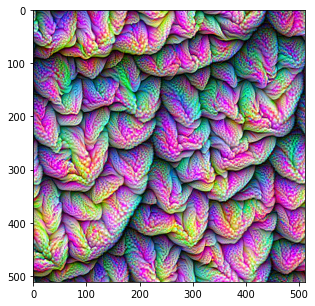

In [ ]:
config["custom_func"] = custom_func_1
out_1 = dreamy_boi.deep_dream(config)
plt.imshow(out_1)
plt.show()

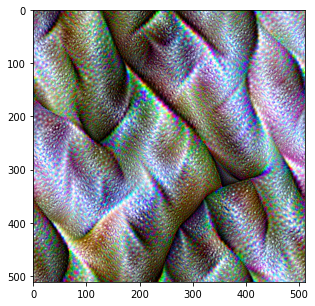

In [ ]:
config["custom_func"] = custom_func_2
out_2 = dreamy_boi.deep_dream(config)
plt.imshow(out_2)
plt.show()

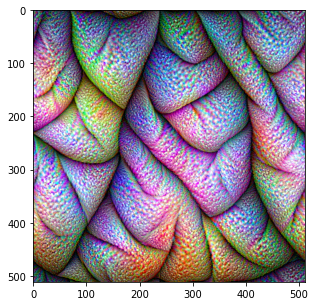

In [ ]:
def custom_func_combined(layer_outputs):
    loss = layer_outputs[0][74].mean() + layer_outputs[1][88].mean()
    return loss
    
config["custom_func"] = custom_func_combined
out_blend = dreamy_boi.deep_dream(config)
plt.imshow(out_blend)
plt.show()

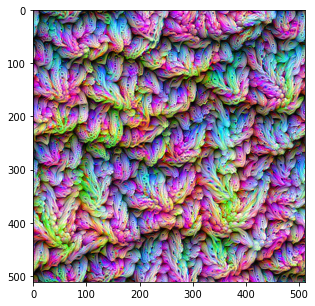

In [ ]:
def custom_func_diff(layer_outputs):
    loss = layer_outputs[0][74].mean() - layer_outputs[1][88].mean()
    return loss

config["custom_func"] = custom_func_diff
out_diff = dreamy_boi.deep_dream(config)
plt.imshow(out_diff)
plt.show()

## Gradient masks

<img src = "https://github.com/Mayukhdeb/torch-dreams/blob/master/images/6_grad_masks.jpeg?raw=true">

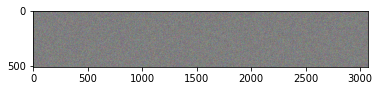

True

In [ ]:
image_sample = (np.random.rand(512,512*6,3).astype(np.float32) *255).astype(np.uint8)

plt.imshow(image_sample)
plt.show()
cv2.imwrite("noise_long.jpg", image_sample)

In [ ]:
def roll(im, shift):
    im = np.roll(im, shift, axis = 1)
    return im

grad_mask =  1- np.abs(1- cv2.rotate(np.repeat(np.linspace(2, 0, 512),512*3).reshape(1024,256,3).astype(np.float32) ,cv2.ROTATE_90_CLOCKWISE))
grad_mask = cv2.resize(grad_mask, (512*6, 512))**3
grad_mask_l = roll(grad_mask, -300)
grad_mask_r = roll(grad_mask, 300)
grad_mask_ll = roll(grad_mask, -450*2)
grad_mask_rr = roll(grad_mask, 450*2)
grad_mask_lll =  cv2.resize(cv2.rotate(np.repeat(np.linspace(0, 1, 512)**2,512*3).reshape(1024,256,3).astype(np.float32) ,cv2.ROTATE_90_CLOCKWISE), (512*6, 512))**2.5
grad_mask_rrr =  cv2.resize(cv2.rotate(np.repeat(np.linspace(1, 0, 512)**2,512*3).reshape(1024,256,3).astype(np.float32) ,cv2.ROTATE_90_CLOCKWISE), (512*6, 512))**2.5

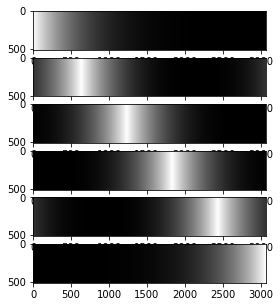

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize = (20,5))

ax.flat[0].imshow(grad_mask_lll)
ax.flat[1].imshow(grad_mask_ll)
ax.flat[2].imshow(grad_mask_l)

ax.flat[3].imshow(grad_mask_r)
ax.flat[4].imshow(grad_mask_rr)
ax.flat[5].imshow(grad_mask_rrr)

grad_masks = [
              grad_mask_lll,
              grad_mask_ll,
              grad_mask_l,
              grad_mask_r,
              grad_mask_rr,
              grad_mask_rrr
]

In [ ]:
def make_custom_func(layer_number = 0, channel_number= 0): 
    def custom_func(layer_outputs):
        loss = layer_outputs[layer_number][channel_number].mean()
        return loss
    return custom_func

channels = [7,31,115,120,74,7]

custom_funcs = []
for c in channels:
    custom_funcs.append(make_custom_func(channel_number = c))

In [ ]:
layers_to_use = [model.Mixed_6c.branch7x7_1.conv]

config = {
    "image_path": "noise_long.jpg",
    "layers": layers_to_use,
    "octave_scale": 1.1,  ## 1.1
    "num_octaves": 20,  ## 14
    "iterations": 100,   ## 100
    "lr": 0.04, ## 0.05
    "max_rotation": 0.7,
    "gradient_smoothing_coeff": None,
    "gradient_smoothing_kernel_size": None,
    "grad_mask": grad_masks,
    "custom_func":  custom_funcs,
}

In [ ]:
out = dreamy_boi.deep_dream_with_masks(config)

100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


In [ ]:
plt.rcParams['figure.figsize'] =20, 20
plt.imshow(out)
plt.show()

In [ ]:
out_p = cv2.cvtColor((out*255), cv2.COLOR_BGR2RGB)
cv2.imwrite("grad_masks.jpg", out_p)

True